In [1]:

import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")


In [2]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')
data.drop("KyleLambda", axis=1, inplace=True, errors='ignore')

Số flash (1/ngày bận): 7 — days=['2025-10-10', '2025-10-03', '2025-10-05', '2025-09-25', '2025-10-07', '2025-10-09', '2025-09-22', '2025-10-01']


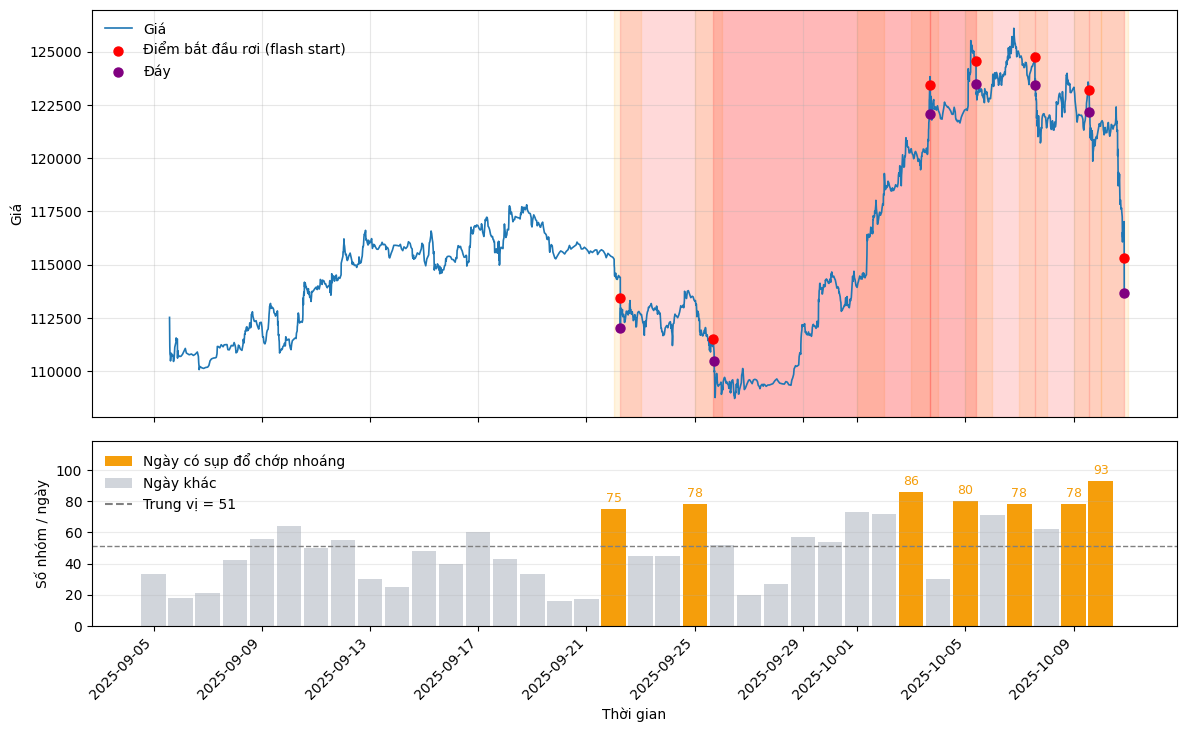

            buckets_per_day  window_hours_median  window_hours_min  window_hours_max
day                                                                                 
2025-09-05               33                  NaN               NaN               NaN
2025-09-06               18                31.09             30.27             31.91
2025-09-07               21                43.74             33.73             52.10
2025-09-08               42                44.59             32.57             56.42
2025-09-09               56                24.49             19.22             32.23
2025-09-10               64                20.41             13.58             23.31
2025-09-11               50                22.86             16.23             25.99
2025-09-12               55                21.16             18.84             25.34
2025-09-13               30                25.84             23.00             29.28
2025-09-14               25                41.33             30.8

In [3]:


# ===== INPUT =====
df = data.copy()
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').set_index('Time')

N = 50                 # độ dài cửa sổ VPIN (để tính "bucket clock")
m_fwd = 3              # số bucket nhìn tới để đo drawdown (start -> trough)
min_abs_drop = -0.008  # ngưỡng rơi tối thiểu để coi là flash (0.8%)
tz = df.index.tz

# ===== Buckets/day & "bucket clock" =====
per_day = (
    df.assign(day=(df.index.tz_convert(tz).date if tz else df.index.date))
      .groupby('day').size().rename('buckets_per_day')
)

idx = df.index
earlier_idx = idx.to_series().shift(N-1)
df['vp_window_hours'] = (idx.to_series() - earlier_idx).dt.total_seconds()/3600.0

# ===== Drawdown tương lai (dd_m) & trough =====
def forward_drawdown(s_price: pd.Series, m: int):
    fut = pd.concat([s_price.shift(-k) for k in range(1, m+1)], axis=1)
    fwd_min = fut.min(axis=1)
    dd_m = (fwd_min / s_price) - 1
    return dd_m, fut

dd_m, fut_matrix = forward_drawdown(df['Price'], m_fwd)

# ===== CHỌN 8 NGÀY "BẬN" NHẤT rồi lấy 1 flash sâu nhất/ngày
busy_days = per_day.sort_values(ascending=False).head(8).index  # kiểu date

starts, troughs = [], []
for d in busy_days:
    mask_day = (dd_m.index.tz_convert(tz).date == d) if tz else (dd_m.index.date == d)
    dd_day = dd_m[mask_day]
    if dd_day.empty:
        continue
    t_star = dd_day.idxmin()
    if np.isnan(dd_m.loc[t_star]) or dd_m.loc[t_star] > min_abs_drop:
        continue
    row = fut_matrix.loc[t_star].values
    j = int(np.nanargmin(row))  # 0..m_fwd-1
    trough_pos = df.index.get_loc(t_star) + (j+1)
    trough_pos = max(0, min(trough_pos, len(df.index)-1))
    t_trough = df.index[trough_pos]
    starts.append(t_star); troughs.append(t_trough)

starts = pd.DatetimeIndex(sorted(starts))
troughs = pd.DatetimeIndex([t for _, t in sorted(zip(starts, troughs))])
flash_days = {(t.tz_convert(tz).date if tz else t.date()) for t in starts}  # set ngày có flash

print(f"Số flash (1/ngày bận): {len(starts)} — days={list(map(str, busy_days))}")

# ===== VẼ HÌNH FLASH + BUCKET/DAY (OPTIONAL, GIỮ NGUYÊN CODE CŨ) =====
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 1, height_ratios=[2.2, 1], hspace=0.08)
ax_p = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[1, 0], sharex=ax_p)

# --- Panel trên: GIÁ + flash ---
ax_p.plot(df.index, df['Price'], label='Giá', linewidth=1.2)

# Tô nền các ngày bận
for d in busy_days:
    d0 = pd.Timestamp(d).tz_localize(tz) if tz else pd.Timestamp(d)
    d1 = d0 + pd.Timedelta(days=1)
    ax_p.axvspan(d0, d1, color='orange', alpha=0.12, zorder=0)

# Markers
if len(starts):
    ax_p.scatter(starts, df.loc[starts,'Price'], s=42, color='red',
                 label='Điểm bắt đầu rơi (flash start)', zorder=3)
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs,'Price'], s=42, color='purple',
                 label='Đáy', zorder=3)
for st, tr in zip(starts, troughs):
    if pd.notna(tr) and tr >= st:
        ax_p.axvspan(st, tr, alpha=0.15, color='red')

ax_p.set_ylabel('Giá')
ax_p.grid(alpha=.3)
ax_p.legend(loc='upper left', frameon=False)

# --- Panel dưới: SỐ BUCKET MỖI NGÀY (highlight ngày có flash) ---
day_start = (df.index.min().tz_convert(tz).normalize() if tz else df.index.min().normalize())
day_end   = (df.index.max().tz_convert(tz).normalize() if tz else df.index.max().normalize())
all_days  = pd.date_range(day_start, day_end, freq='D')

per_day_ts = per_day.reindex(all_days.date).fillna(0)

if tz is not None:
    x_days = all_days if all_days.tz is not None else all_days.tz_localize(tz)
    if all_days.tz is not None and all_days.tz != tz:
        x_days = all_days.tz_convert(tz)
else:
    x_days = all_days

flash_days_ts = pd.DatetimeIndex(sorted({
    (t.tz_convert(tz).normalize() if tz else t.normalize()) for t in starts
}))

flash_mask = pd.Index(x_days).isin(flash_days_ts)

flash_color = '#f59e0b'   # cam
other_color = '#d1d5db'   # xám nhạt
bar_colors = np.where(flash_mask, flash_color, other_color)

bars = ax_b.bar(x_days, per_day_ts.values, color=bar_colors, width=0.9, align='center',
                edgecolor='none')

vals = per_day_ts.values.astype(float)
med_bpd = np.nanmedian(np.where(vals > 0, vals, np.nan))
if not np.isnan(med_bpd):
    ax_b.axhline(med_bpd, ls='--', lw=1.0, color='gray')
    med_label = f'Trung vị = {med_bpd:.0f}'
else:
    med_label = None

max_y = max(per_day_ts.max(), med_bpd if not np.isnan(med_bpd) else 0)
ax_b.set_ylim(0, max_y*1.28)

base_offset = max(2, 0.03 * max_y)
for xi, yi, is_flash in zip(x_days, per_day_ts.values, flash_mask):
    if is_flash and yi > 0:
        y_text = yi + base_offset
        if not np.isnan(med_bpd):
            y_text = max(y_text, med_bpd + base_offset)
        ax_b.text(xi, y_text, f'{int(yi)}', ha='center', va='bottom',
                  fontsize=9, color=flash_color, clip_on=False)

ax_b.set_ylabel('Số nhóm / ngày')
ax_b.grid(alpha=.25, axis='y')

legend_handles = [
    Patch(facecolor=flash_color, edgecolor='none', label='Ngày có sụp đổ chớp nhoáng'),
    Patch(facecolor=other_color, edgecolor='none', label='Ngày khác'),
]
if med_label:
    legend_handles.append(plt.Line2D([0],[0], ls='--', color='gray', label=med_label))
ax_b.legend(handles=legend_handles, frameon=False, loc='upper left')

plt.setp(ax_b.get_xticklabels(), rotation=45, ha='right')
ax_p.tick_params(labelbottom=False)
plt.xlabel('Thời gian')
plt.tight_layout()
plt.show()

# ===== BẢNG TÓM TẮT =====
summary = pd.DataFrame({'buckets_per_day': per_day}).assign(
    window_hours_median=lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).median(),
    window_hours_min   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).min(),
    window_hours_max   =lambda s: df['vp_window_hours'].groupby(df.index.tz_convert(tz).date if tz else df.index.date).max(),
)
print(summary.round(2).to_string())

# =====================================================================
#  ➤ TẠO LABEL TỪ starts (3 bucket trước flash crash = 1)
# =====================================================================
df["label"] = 0
lookback = 3

for st in starts:
    pos = df.index.get_loc(st)
    lb = max(0, pos - lookback)
    df.iloc[lb:pos+1, df.columns.get_loc("label")] = 1

print("\nlabel value_counts:")
print(df["label"].value_counts())

# =====================================================================
#  ➤ RANDOM FOREST: chuẩn bị feature + train + p_smooth
# =====================================================================
COOLDOWN  = pd.Timedelta("15min")
MATCH_WIN = pd.Timedelta("20min")
TEST_SIZE = 0.2

# loại một số cột không nên dùng làm feature nếu có
drop_cols = [
    "label",
    "rf_prob", "logreg_prob", "xgb_prob",
    "prob_smooth", "p_raw", "p_smooth",
    "weak_price", "high_vpin", "wide_spread",
]

feature_cols = [c for c in df.columns if c not in drop_cols]
print("\nSố feature:", len(feature_cols))
print("Feature:", feature_cols)

X = df[feature_cols].values
y = df["label"].values
times = df.index

print("X:", X.shape)
print("y:", y.shape, "— số label=1:", y.sum(), "số label=0:", (y == 0).sum())

n = len(df)
split_idx = int((1 - TEST_SIZE) * n)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
t_train, t_test = times[:split_idx], times[split_idx:]

print("Train size:", X_train.shape[0], "— Test size:", X_test.shape[0])

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_prob_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

print("\n=== Random Forest – bucket-level (thr=0.5, chỉ để tham khảo) ===")
print(classification_report(y_test, y_pred_test))

# Xác suất cho toàn bộ df + smoothing
rf_prob_full = rf.predict_proba(X)[:, 1]
df["rf_prob"]  = rf_prob_full
df["p_smooth"] = df["rf_prob"].rolling(5, min_periods=1).mean()

print("\nMô tả phân phối p_smooth:")
print(df["p_smooth"].describe())

# =====================================================================
#  ➤ HÀM TẠO ALERT + EVALUATE THRESHOLD (EVENT-LEVEL)
# =====================================================================
def gen_alerts_from_thr(thr: float) -> pd.DatetimeIndex:
    alerts = []
    last = None
    for t, p in zip(df.index, df["p_smooth"].values):
        if p >= thr:
            if (last is None) or (t - last >= COOLDOWN):
                alerts.append(t)
                last = t
    return pd.DatetimeIndex(alerts)

def eval_threshold(thr: float):
    alerts = gen_alerts_from_thr(thr)

    # alerts/ngày
    if len(alerts):
        days = alerts.normalize()
        counts = pd.Series(1, index=days).groupby(level=0).size()
        alerts_per_day = counts.mean()
    else:
        alerts_per_day = 0.0

    tp = fp = 0
    matched = set()
    for a in alerts:
        cand = [s for s in starts if abs(a - s) <= MATCH_WIN and s not in matched]
        if cand:
            s0 = min(cand, key=lambda x: abs(a - x))
            matched.add(s0)
            tp += 1
        else:
            fp += 1

    fn = len(starts) - tp
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f2   = (5 * prec * rec) / (4 * prec + rec + 1e-9) if (prec + rec) > 0 else 0.0

    return {
        "thr": thr,
        "n_alerts": len(alerts),
        "alerts_per_day": alerts_per_day,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": prec,
        "recall": rec,
        "f2": f2,
        "alerts": alerts,
    }


In [4]:

# =====================================================================
#  ➤ QUÉT NGƯỠNG THEO F2
# =====================================================================
q90  = float(df["p_smooth"].quantile(0.90))
q999 = float(df["p_smooth"].quantile(0.999))
if q90 == q999:
    q999 = float(df["p_smooth"].max())

thresholds = np.linspace(q90, q999, 40)
print(f"\nScan threshold range: {thresholds[0]:.6f} → {thresholds[-1]:.6f}")

rows = []
best = None
for thr in thresholds:
    res = eval_threshold(thr)
    rows.append(res)
    if (best is None) or (res["f2"] > best["f2"]):
        best = res

res_df = pd.DataFrame(rows)
print("\n== TOP 10 NGƯỠNG TỐT NHẤT THEO EVENT-LEVEL F2 (ưu tiên recall) ==")
print(
    res_df.sort_values("f2", ascending=False)[
        ["thr", "n_alerts", "alerts_per_day", "tp", "fp", "fn", "precision", "recall", "f2"]
    ].head(10)
)

print("\n== NGƯỠNG ĐƯỢC CHỌN (best theo F2) ==")
print(f"Threshold = {best['thr']:.6f}")
print(f"Số ALERT  = {best['n_alerts']} (≈ {best['alerts_per_day']:.2f} alerts/ngày)")
print(f"TP={best['tp']}, FP={best['fp']}, FN={best['fn']}")
print(f"Event-level precision = {best['precision']:.3f}")
print(f"Event-level recall    = {best['recall']:.3f}")
print(f"Event-level F2        = {best['f2']:.3f}")

final_alerts = best["alerts"]
BEST_THR = best["thr"]



Scan threshold range: 0.050373 → 0.720661

== TOP 10 NGƯỠNG TỐT NHẤT THEO EVENT-LEVEL F2 (ưu tiên recall) ==
         thr  n_alerts  alerts_per_day  tp  fp  fn  precision    recall  \
35  0.651913         5            1.25   4   1   3   0.800000  0.571429   
34  0.634726         5            1.25   4   1   3   0.800000  0.571429   
33  0.617539         6            1.50   4   2   3   0.666667  0.571429   
32  0.600353         6            1.50   4   2   3   0.666667  0.571429   
31  0.583166         7            1.75   4   3   3   0.571429  0.571429   
30  0.565979         7            1.75   4   3   3   0.571429  0.571429   
29  0.548792         8            2.00   4   4   3   0.500000  0.571429   
28  0.531605         8            2.00   4   4   3   0.500000  0.571429   
27  0.514418         8            2.00   4   4   3   0.500000  0.571429   
26  0.497232         9            2.25   4   5   3   0.444444  0.571429   

          f2  
35  0.606061  
34  0.606061  
33  0.588235  
32  

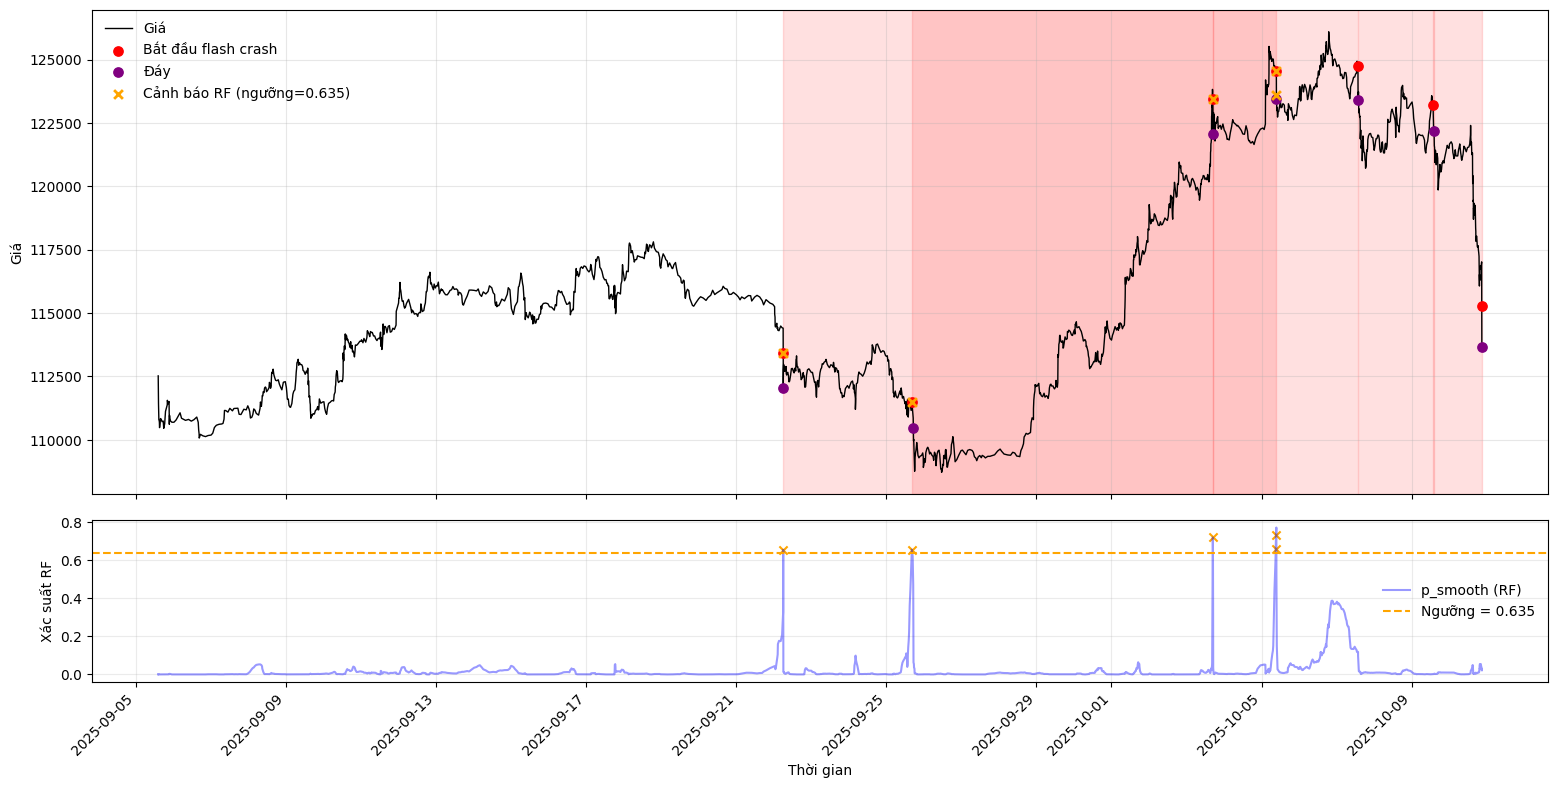

In [5]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.08)

ax_p = fig.add_subplot(gs[0, 0])
ax_a = fig.add_subplot(gs[1, 0], sharex=ax_p)

# ===============================
#  PANEL 1 – GIÁ + FLASH + CẢNH BÁO
# ===============================
ax_p.plot(df.index, df["Price"], color="black", label="Giá", linewidth=1)

# Điểm bắt đầu flash crash
if len(starts):
    ax_p.scatter(starts, df.loc[starts, "Price"],
                 color="red", s=45, label="Bắt đầu flash crash", zorder=3)

# Đáy
if len(troughs):
    ax_p.scatter(troughs, df.loc[troughs, "Price"],
                 color="purple", s=45, label="Đáy", zorder=3)

# Tô vùng từ start → trough
for st, tr in zip(starts, troughs):
    if tr >= st:
        ax_p.axvspan(st, tr, color="red", alpha=0.12)

# Cảnh báo của Random Forest
if len(final_alerts):
    ax_p.scatter(final_alerts, df.loc[final_alerts, "Price"],
                 color="orange", s=40, marker="x", linewidths=2,
                 label=f"Cảnh báo RF (ngưỡng={BEST_THR:.3f})", zorder=4)

ax_p.set_ylabel("Giá")
ax_p.legend(loc="upper left", frameon=False)
ax_p.grid(alpha=0.3)

# Ẩn nhãn X ở panel trên
ax_p.tick_params(labelbottom=False)

# ===============================
#  PANEL 2 – XÁC SUẤT p_smooth + NGƯỠNG
# ===============================
ax_a.plot(df.index, df["p_smooth"], color="blue", alpha=0.4, label="p_smooth (RF)")
ax_a.axhline(BEST_THR, color="orange", linestyle="--",
             label=f"Ngưỡng = {BEST_THR:.3f}")

# Đánh dấu vị trí alert
if len(final_alerts):
    ax_a.scatter(final_alerts, df.loc[final_alerts, "p_smooth"],
                 color="orange", marker="x", s=35)

ax_a.set_ylabel("Xác suất RF")
ax_a.set_xlabel("Thời gian")
ax_a.grid(alpha=0.25)
ax_a.legend(frameon=False)

# ===============================
#  CHỈNH LẠI LAYOUT – KHÔNG ĐÈ X-LABEL
# ===============================
fig.subplots_adjust(
    bottom=0.12,
    left=0.07,
    right=0.98,
    top=0.96,
    hspace=0.05
)

# Xoay nhãn thời gian ở panel dưới
for label in ax_a.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

plt.show()
